## Predicción de Costes de Seguro Médico

#### Comprensión 
Las compañías de seguros de salud operan bajo un modelo de gestión de riesgos. Para que el negocio sea sostenible y rentable, la aseguradora debe cobrar una prima (precio del seguro) que sea proporcional a la probabilidad de que el cliente incurra en gastos médicos. Si la prima es muy baja para un cliente de alto riesgo, la compañía pierde dinero; si es muy alta para un cliente de bajo riesgo, el cliente se irá a la competencia. Factores fisiológicos y de estilo de vida, como el índice de masa corporal (BMI) o el tabaquismo, son determinantes clave en la salud futura de una persona.

#### Descripción del problema
La importante compañía 4Geeks Insurance S.L. busca optimizar su estrategia de precios. Actualmente, necesitan un sistema más preciso para calcular la prima que debe asumir cada cliente, basándose en su perfil de riesgo real.

Para ello, la empresa ha colaborado con un equipo médico y ha recopilado datos históricos y fisiológicos (edad, género, BMI, hijos, región y hábitos de fumar). El objetivo es desarrollar un modelo predictivo capaz de estimar el coste médico anual de un nuevo cliente. Esto permitirá a la aseguradora ajustar las tarifas de forma personalizada, asegurando la cobertura de los gastos médicos previstos y manteniendo la competitividad en el mercado.

# Exploratory Data Analysis (EDA)

### 0. Importar liberías

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

import math
import json

import pickle

### 1. Carga de información

In [2]:
link = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
df = pd.read_csv(link)
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 2. Exploración y limpieza
**2.1. Comprensión de datos**

In [3]:
print(f'El dataframe contiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataframe contiene 1338 filas y 7 columnas.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


* `age`. Edad del beneficiario principal (numérico)
* `sex`. Género del beneficiario principal (categórico)
* `bmi`. índice de masa corporal (numérico)
* `children`. Número de niños/dependientes cubiertos por un seguro médico (numérico)
* `smoker`. ¿Es fumador? (categórico)
* `region`. Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)
* `charges`. Prima del seguro médico (numérico) - Target

* Hay 1338 filas que corresponden a cada cliente de la compañía de seguros
* Los datos cuentan con 4 características numéricas y 3 características categóricas.

**2.2. Identificando nulos y duplicados**

In [5]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [6]:
num_duplicados = df.duplicated().sum()[df.duplicated().sum()>0]

print(f"Número de filas duplicadas encontradas: {num_duplicados}")

Número de filas duplicadas encontradas: [1]


**2.3. Eliminando información irrelevante**

El dataframe no cuenta con una columna de ID que debamos eliminar, solo debemos eliminar duplciados

In [7]:
df_clean = df.drop_duplicates(keep='first')
print(f"Tamaño original: {df.shape}")
print(f"Tamaño después de eliminar duplicados: {df_clean.shape}")

Tamaño original: (1338, 7)
Tamaño después de eliminar duplicados: (1337, 7)


### 3. Análisis univariante
**3.1. Dividir el Dataset en categoricos y numericos**

In [8]:
df_copy = df_clean.copy()
df_copy.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [9]:
info_data = df_copy.dtypes
numerical_column = df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_column = df_copy.select_dtypes(include=['object']).columns.tolist()

**3.2. Análisis sobre variables categóricas**

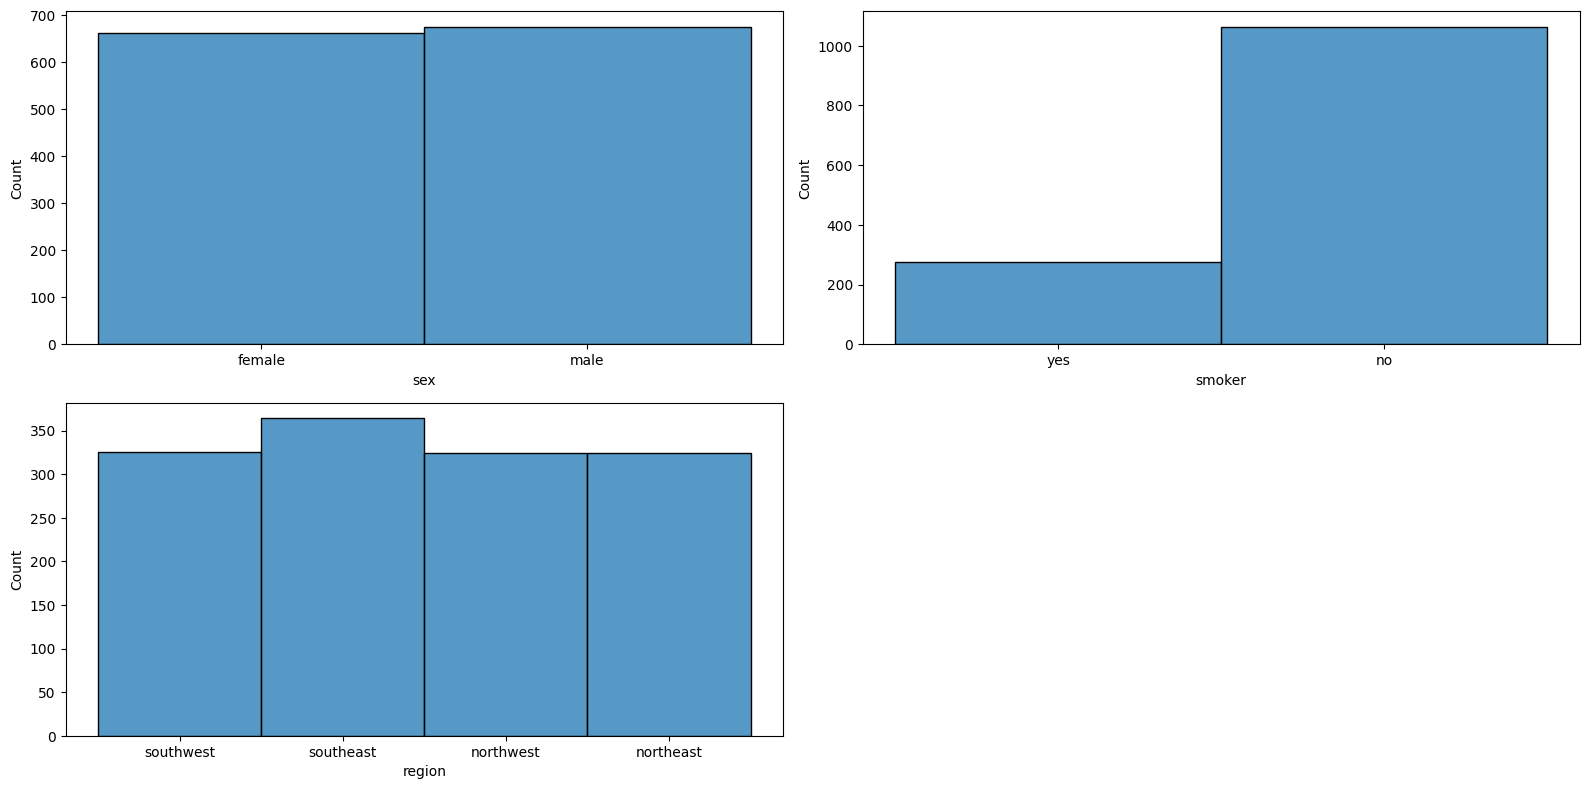

In [10]:
# Ajustes para la visualización de filas y columnas de gráficos
n = len(categorical_column)
n_cols = 2
n_rows = math.ceil(n / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Ajustar que el axis siempre sea 2D
axis = np.array(axis)
if axis.ndim == 1:
    axis = axis.reshape(-1, n_cols)


for index, name_col in enumerate(categorical_column):
    r, c = divmod(index, n_cols)
    sns.histplot(ax = axis[r, c], data=df_copy, x = name_col)
    if len(df_copy[name_col].unique()) > 5:
        axis[r, c].tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos (Esto sirve si hay un número impar a revisar)
for idx in range(n, n_rows * n_cols):
    r, c = divmod(idx, n_cols)
    fig.delaxes(axis[r, c])


plt.tight_layout()
plt.show()

* `sex`: Hay bastante equidad entre los sexos de los clientes.
* `smoker`: La mayoría son no fumadores y una cuarta proporcion si lo son .
* `region`: Esta muy equitativa la región a la que pertenecen pero hay un poco mas en la región sur-este.

**3.3. Análisis sobre variables numéricas**

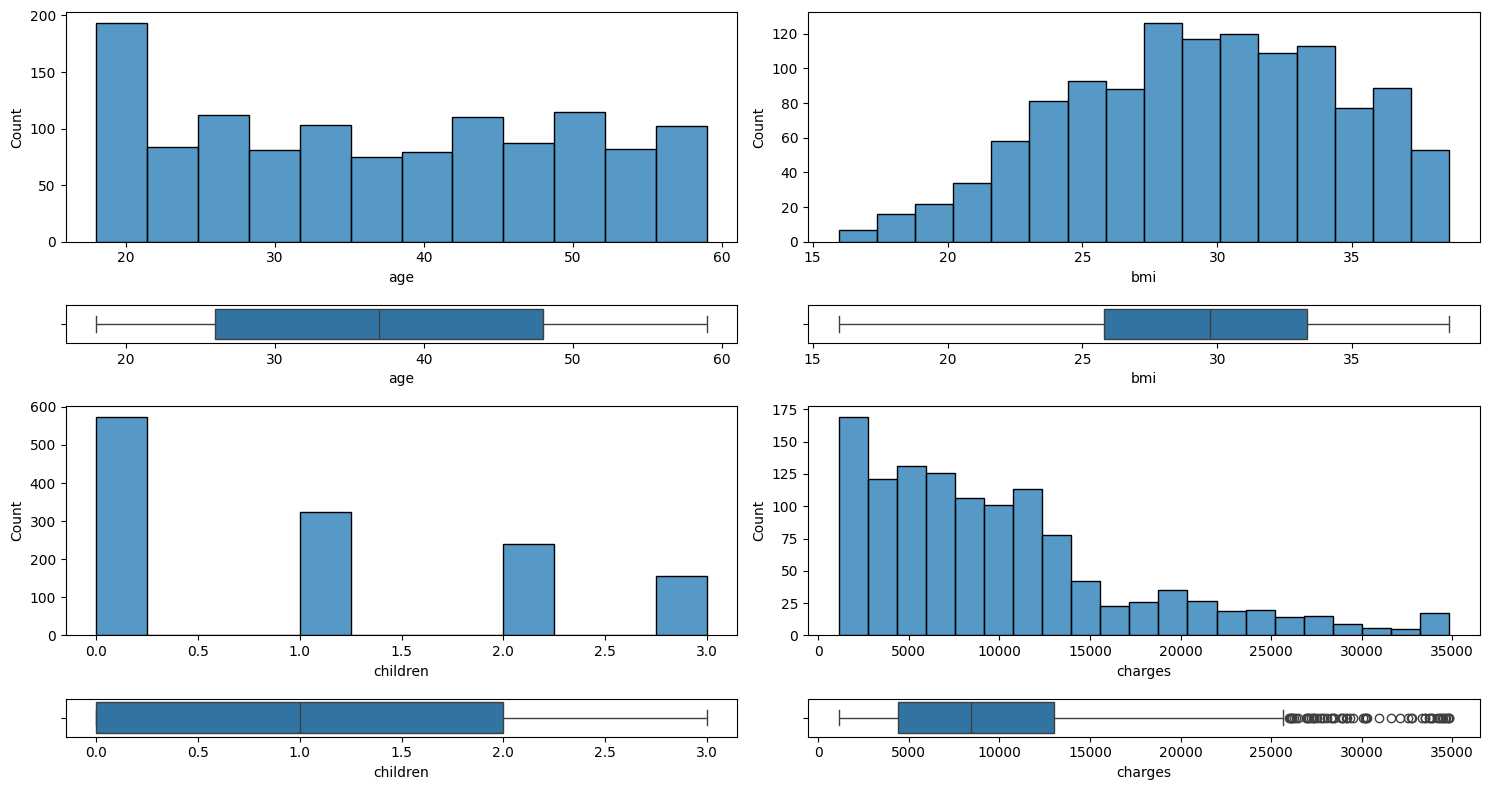

In [11]:
n = len(numerical_column)
n_cols = 2
n_rows = math.ceil(n / n_cols) * 2  # Dos filas por variable para histogramas y boxplots

# Alternar alturas: filas pares grandes para historigraam e impares pequeñas para boxplot
height_ratios = []
for _ in range(n_rows // 2):
    height_ratios.extend([6, 1])
if len(height_ratios) < n_rows:
    height_ratios.append(1)  # Por si hay una fila extra

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 2 * n_rows), gridspec_kw={'height_ratios': height_ratios})

# Asegurar que axis siempre sea 2D
axis = np.array(axis)
if axis.ndim == 1:
    axis = axis.reshape(-1, n_cols)


for idx, col in enumerate(numerical_column):

    #Limitar los datos a los valores por debajo del percentil 90
    datos_filtrados = df_copy[col].copy()
    limite = datos_filtrados.quantile(0.90)
    datos_filtrados = datos_filtrados[datos_filtrados <= limite]

    # Calcular la posición en la cuadrícula
    grid_pos = idx // n_cols
    col_pos = idx % n_cols
    row_hist = grid_pos * 2
    row_box = row_hist + 1

    sns.histplot(ax=axis[row_hist, col_pos], data=datos_filtrados.to_frame(), x=datos_filtrados.name)
    sns.boxplot(ax=axis[row_box, col_pos], data=datos_filtrados.to_frame(), x=datos_filtrados.name)


# Ocultar subplots vacíos (Esto sirve si hay un número impar a revisar)
for idx in range(n, (n_rows // 2) * n_cols):
    grid_pos = idx // n_cols
    col_pos = idx % n_cols
    row_hist = grid_pos * 2
    row_box = row_hist + 1
    fig.delaxes(axis[row_hist, col_pos])
    fig.delaxes(axis[row_box, col_pos])

plt.tight_layout()
plt.show()

* Hay una distribución de `age` en la que  mayoría esta en sus 20's, a partir de ahi el resto de gente se encuentra equitativamente hasta casi los 60
* El `bmi` sigue una distribución normal un poco agrupada hacia la derecha por el grupo de los 29
* El gráfico de `children` sigue una distribución decreciente, la mayoría no tiene hijos y va menguando hasta un maximo de 3 que es poco probable.
* Los `charges`o primas del seguro médico la mayoría se encuentran por los 1000 o 2000, a partir de ahi se va distribuyendo hasta una caida por el 15000 en donde empiezan a haber menos cantidad de clientes

### 4. Análisis multivariante
**4.1. Codificación de valor categorico - numericos**

In [12]:
def plot_numerical_analisis(column, numerical_column, name = None, column_info = False):
    
    if name is None:
        name = column

    columna_n = f"{column}_n"
    df_plot = df_copy.copy()
    df_plot[columna_n] = pd.factorize(df_plot[column])[0]

    if column_info:
        print(df_plot[[columna_n, column]].drop_duplicates())

    n = len(numerical_column)
    n_cols = 2
    n_rows = math.ceil(n / n_cols) * 2

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))

    axis = np.array(axis)
    if axis.ndim == 1:
        axis = axis.reshape(-1, n_cols)

    for idx, col in enumerate(numerical_column):
        limite = df_plot[col].quantile(0.90)
        datos_filtrados = df_plot[df_plot[col] <= limite]

        grid_pos = idx // n_cols
        col_pos = idx % n_cols
        row_hist = grid_pos * 2
        row_box = row_hist + 1

        sns.regplot(ax=axis[row_hist, col_pos], data=datos_filtrados, x=col, y=columna_n).set(ylabel=name)
        sns.heatmap(
            datos_filtrados[[col, columna_n]].corr()
            .rename(columns={columna_n: name}, index={columna_n: name}),
            annot=True, fmt=".2f", ax=axis[row_box, col_pos], cbar=False)
        

    for idx in range(n, (n_rows // 2) * n_cols):
        grid_pos = idx // n_cols
        col_pos = idx % n_cols
        row_hist = grid_pos * 2
        row_box = row_hist + 1
        fig.delaxes(axis[row_hist, col_pos])
        fig.delaxes(axis[row_box, col_pos])

    plt.tight_layout()
    plt.show()

* Sex - (variables numéricas)

   sex_n     sex
0      0  female
1      1    male


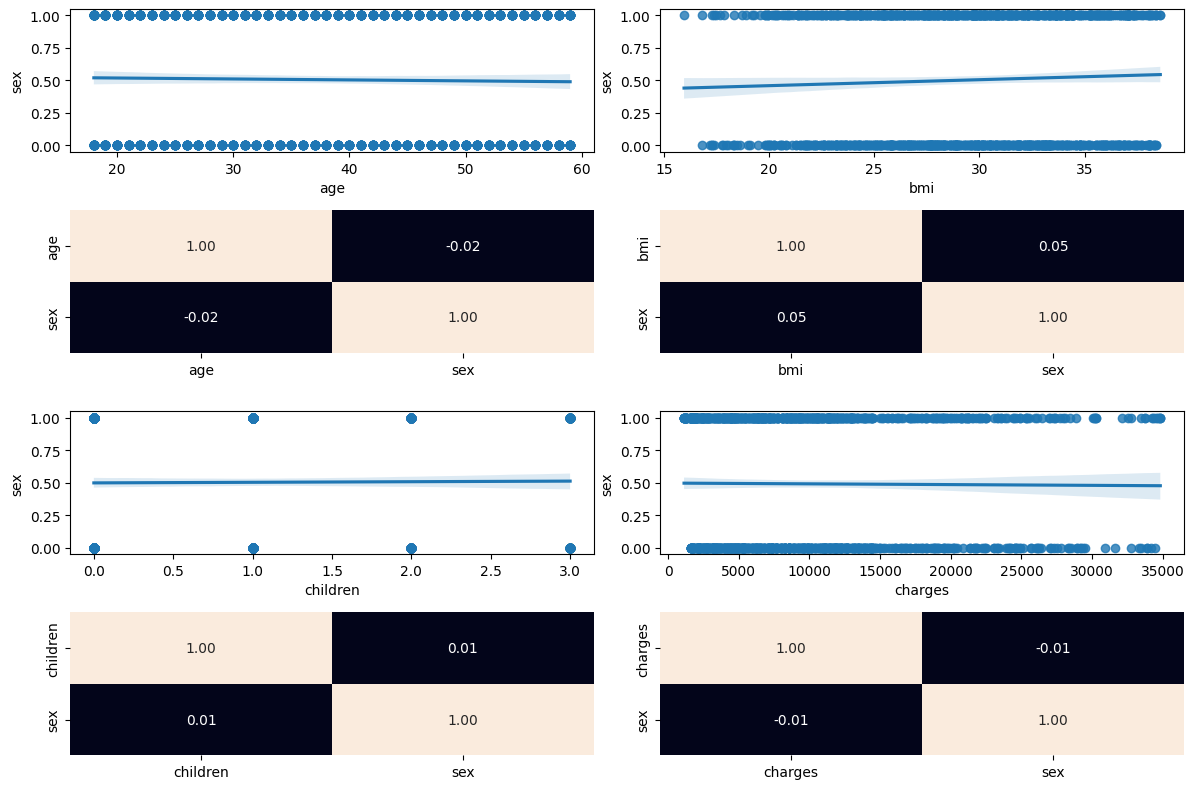

In [13]:
plot_numerical_analisis("sex", numerical_column, column_info=True)

* **Ausencia de Correlaciones Lineales**: A diferencia del caso bancario, aquí los mapas de calor muestran una ausencia total de correlación lineal entre el género y las demás variables. Los coeficientes son extremadamente cercanos a cero en todos los casos (-0.02, 0.05, 0.01, -0.01), lo que indica que el género es una variable muy independiente en este conjunto de datos.

* **Relación con la Prima (Charges)**: Resulta destacable que la correlación entre sex y charges sea prácticamente nula (-0.01). Esto sugiere que el género no parece ser un factor determinante que encarezca o abarate drásticamente el coste del seguro médico por sí solo.

* Smoker - (variables numéricas)

   smoker_n smoker
0         0    yes
1         1     no


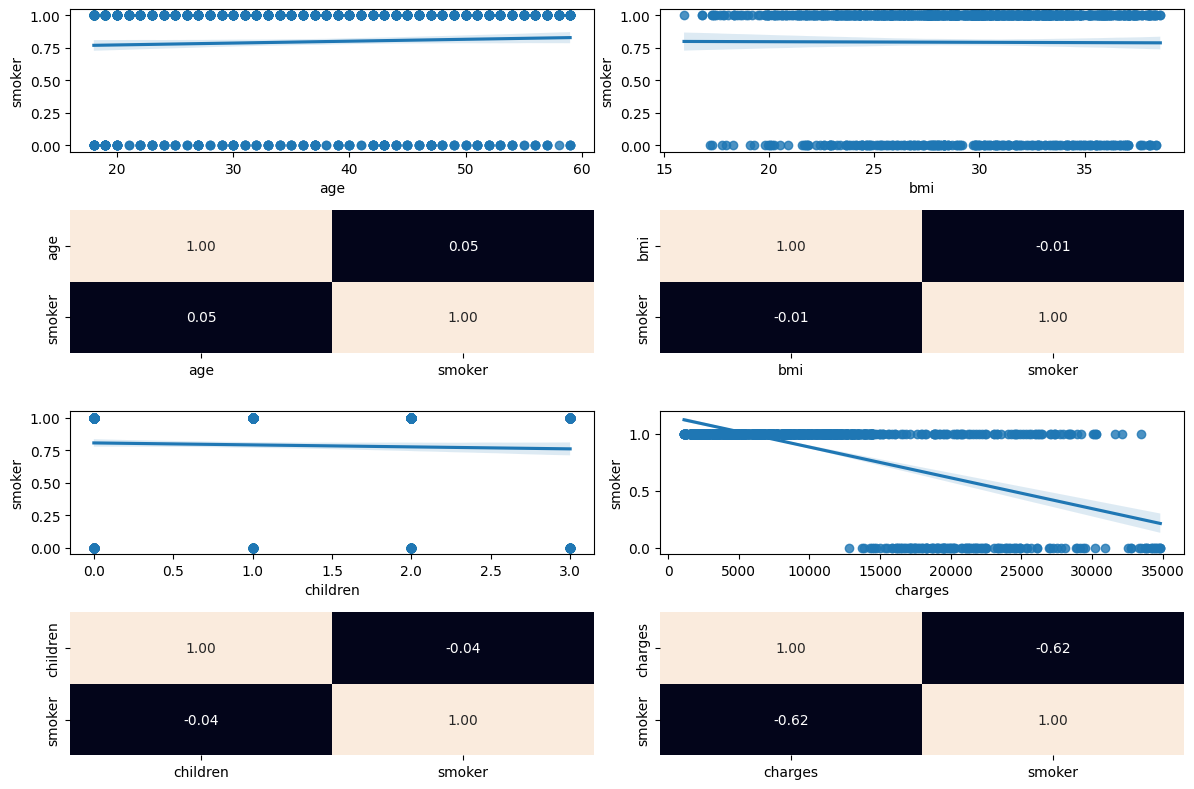

In [14]:
plot_numerical_analisis("smoker", numerical_column, column_info=True)

* **Correlación Determinante**: La relación entre smoker y charges (prima del seguro) presenta una correlación significativa de -0.62. Indica que el estatus de fumador es un predictor crítico para determinar el coste del seguro. Visualmente, el gráfico de dispersión (abajo a la derecha) muestra una clara separación en los costes dependiendo de si el valor es 0 o 1, lo que confirma que esta variable  divide drásticamente a los usuarios en diferentes rangos de precios. Siendo charges el target entonces el dato de fumador tendra mas impacto en la conclusión final del modelo.

* **Independencia del Perfil Demográfico**: Las correlaciones con age (0.05), bmi (-0.01) y children (-0.04) son prácticamente nulas. Esto es un hallazgo curioso: nos dice que el hábito de fumar está distribuido uniformemente en la población; no depende de la edad, del peso, ni del tamaño de la familia.

* Region - (variables numéricas)

   region_n     region
0         0  southwest
1         1  southeast
3         2  northwest
8         3  northeast


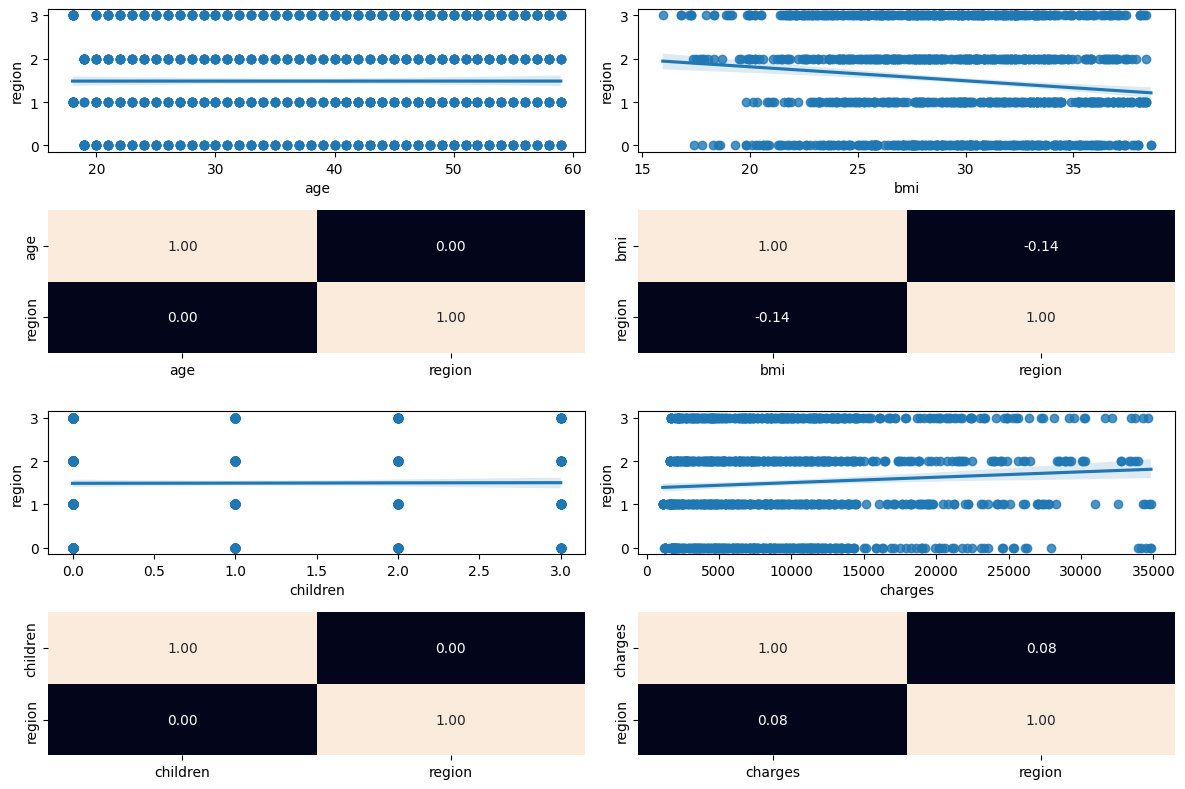

In [15]:
plot_numerical_analisis("region", numerical_column, column_info=True)

* **Correlaciones Débiles o Nulas**: En general, la región muestra relaciones de correlación muy bajas o nulas con el resto de variables. Esto indica que el lugar de residencia es altamente independiente de las características demográficas y fisiológicas.

**4.2. Numerico-Numerico Análisis**

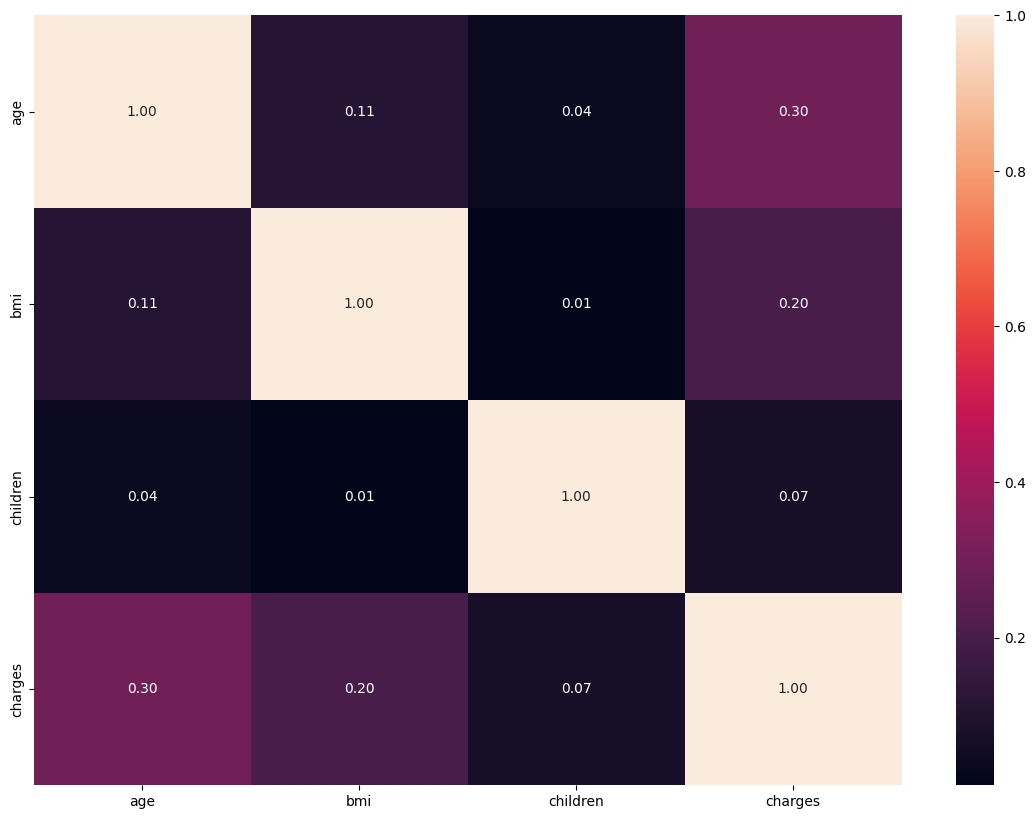

In [16]:
plt.figure(figsize=(14,10))

df_onlyn =  df_copy[numerical_column]

sns.heatmap(df_onlyn.corr().round(2), annot = True, fmt = ".2f")

plt.show()

* Hay una ligera influcneica para `charges` con las columnas de `age` (30%) y `bmi` (20%)
* La correlación entre la `age` y el `bmi` es muy baja siendo de  (11%) entre estas dos  

**4.3. Categorico-Categorico Análisis**

In [17]:
def plot_categorical_analisis(column1, column2):
    fig, axis = plt.subplots(1, 1, figsize=(15, 5))

    sns.countplot(ax=axis, data=df_copy, x=column1, hue=column2)

    plt.tight_layout()
    plt.show()

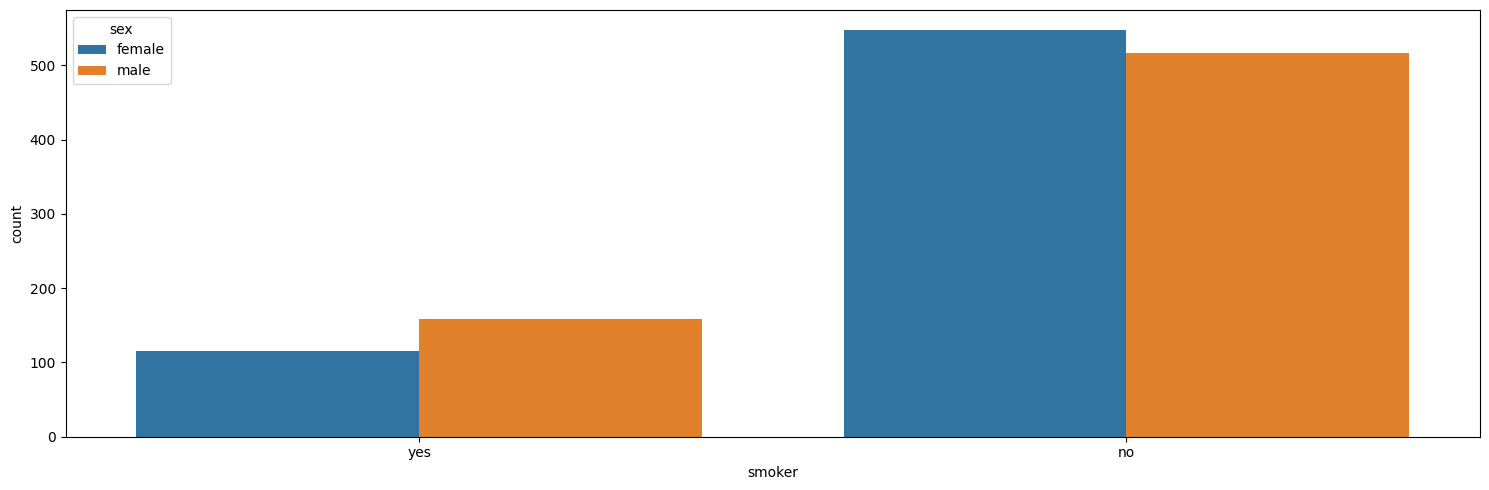

In [19]:
plot_categorical_analisis("smoker", "sex")

* No parece haber una gran correlación entre el género y si son fumadores.
* Parece que hay mas mujeres fumadoras y mas hombres no fumadores por una diferencia muy pequeña

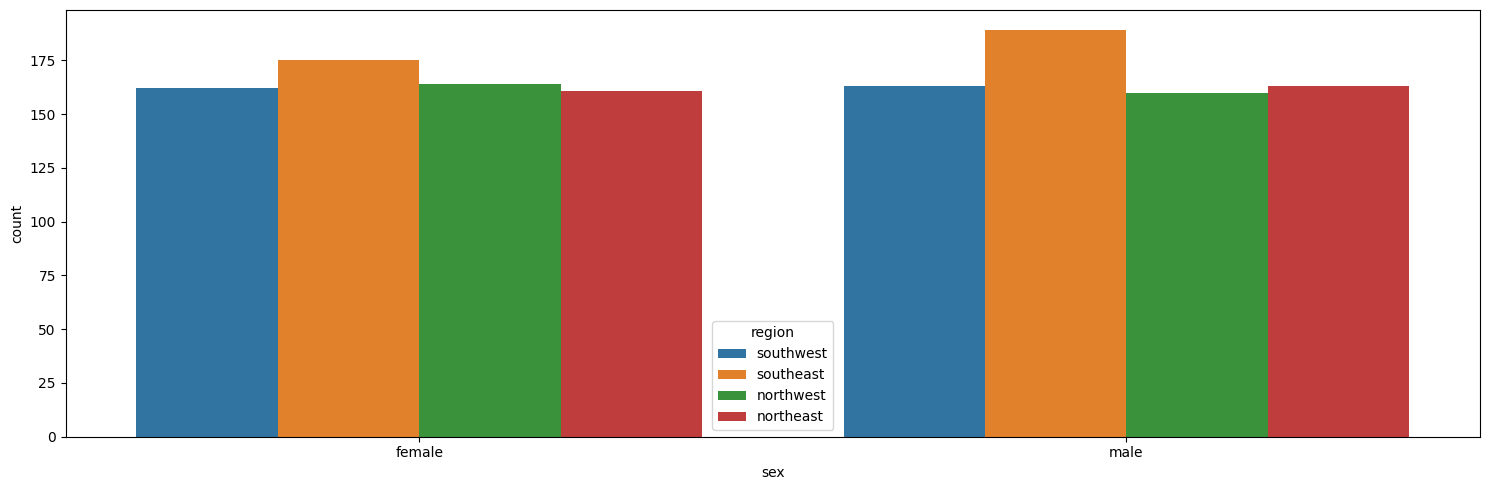

In [21]:
plot_categorical_analisis("sex", "region")

* La mayor parte parece dek sur-este tanto hombres como mujeres

* La variable region es independiente del género.

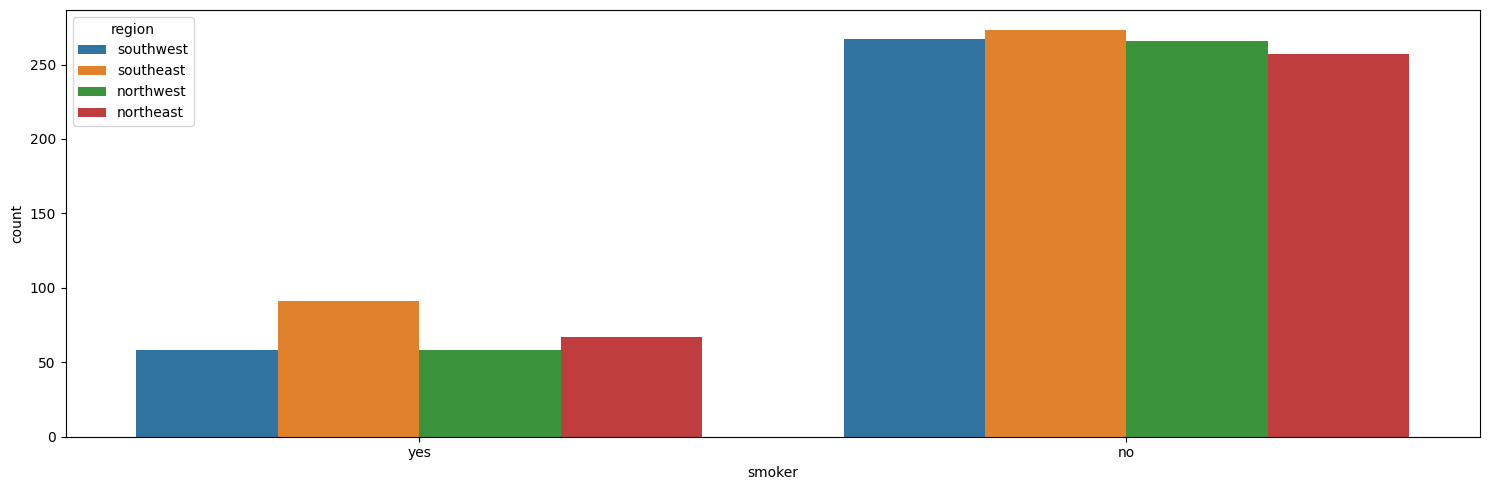

In [22]:
plot_categorical_analisis("smoker", "region")

* Todas las regiones tienen un conteo de no fumadores que ronda los 250 a 275 individuos.
* La región southeast (naranja) tiene la mayor cantidad de fumadores (casi 100 individuos).
* La gran mayoría de la población (los no fumadores), la región no introduce un sesgo en la muestra.

**4.4. Combinación de clases predictoras**

In [23]:
def plot_combination_predictoras(categ1, categ2, numerica):
    fig, axis = plt.subplots(1, 1, figsize=(15, 5))

    sns.barplot(ax=axis, data = df_copy, x = categ1, y = numerica, hue = categ2)

    plt.tight_layout()
    plt.show()

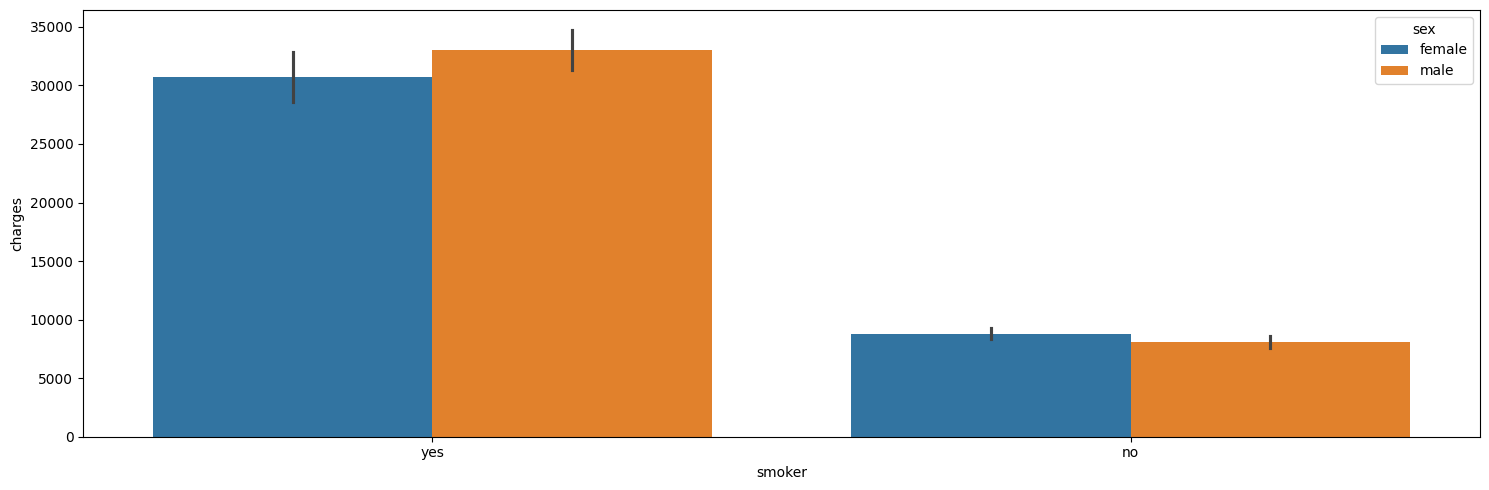

In [25]:
plot_combination_predictoras("smoker", "sex", "charges")

* La prima de un fumador es aproximadamente 3 a 4 veces mayor que la de un no fumador.
* Las mujeres fumadoras (línea naranja a la izquierda) tienen mas cargos llegando a los 32500.
* La predicción de costes para los fumadores será menos precisa (mayor error) que para los no fumadores debido a la gran variabilidad de los costes.

**4.4. Codificación de valores categóricos y almacenamiento de archivos JSON**

In [26]:
df_num_total = df.copy()
lista_cambios = []

for col in df_num_total.columns:
    if df_num_total[col].dtype == 'object':
        df_num_total[f"{col}_n"] = pd.factorize(df_num_total[col])[0]
        lista_cambios.append(col)
        print(df_num_total[[f"{col}_n", col]].drop_duplicates())

print(f"Las siguientes columnas fueron convertidas a numéricas: {lista_cambios}")

   sex_n     sex
0      0  female
1      1    male
   smoker_n smoker
0         0    yes
1         1     no
   region_n     region
0         0  southwest
1         1  southeast
3         2  northwest
8         3  northeast
Las siguientes columnas fueron convertidas a numéricas: ['sex', 'smoker', 'region']


In [27]:
diccionarios_codificacion = {}

for col in lista_cambios:
    col_n = f"{col}_n"
    # Para cada valor de columna se asocia un valor numerico único
    mapeo = {row[col]: row[col_n] for index, row in df_num_total[[col, col_n]].drop_duplicates().iterrows()}
    diccionarios_codificacion[col] = mapeo

for col, mapeo in diccionarios_codificacion.items():
    print(f"Diccionario para {col}:")
    print(mapeo)
    print()

Diccionario para sex:
{'female': 0, 'male': 1}

Diccionario para smoker:
{'yes': 0, 'no': 1}

Diccionario para region:
{'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3}



In [28]:
for col, mapeo in diccionarios_codificacion.items():

    # Escritura
    with open(f"../data/processed/{col}_n.json", "w") as f:
        json.dump(mapeo, f)

    # Lectura
    with open(f"../data/processed/{col}_n.json", "r") as f:
        mapeo_loaded = json.load(f)
    
    #Convierte los balores categóricos a su valor numerico correspondiente usando el diccionario
    df_num_total[col + "_n"] = df_num_total[col].apply(lambda x: mapeo_loaded[x] if not pd.isna(x) else np.nan)

df_num_total

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,1,2
1334,18,female,31.920,0,no,northeast,2205.98080,0,1,3
1335,18,female,36.850,0,no,southeast,1629.83350,0,1,1
1336,21,female,25.800,0,no,southwest,2007.94500,0,1,0


**4.5. Análisis final de correlaciones**

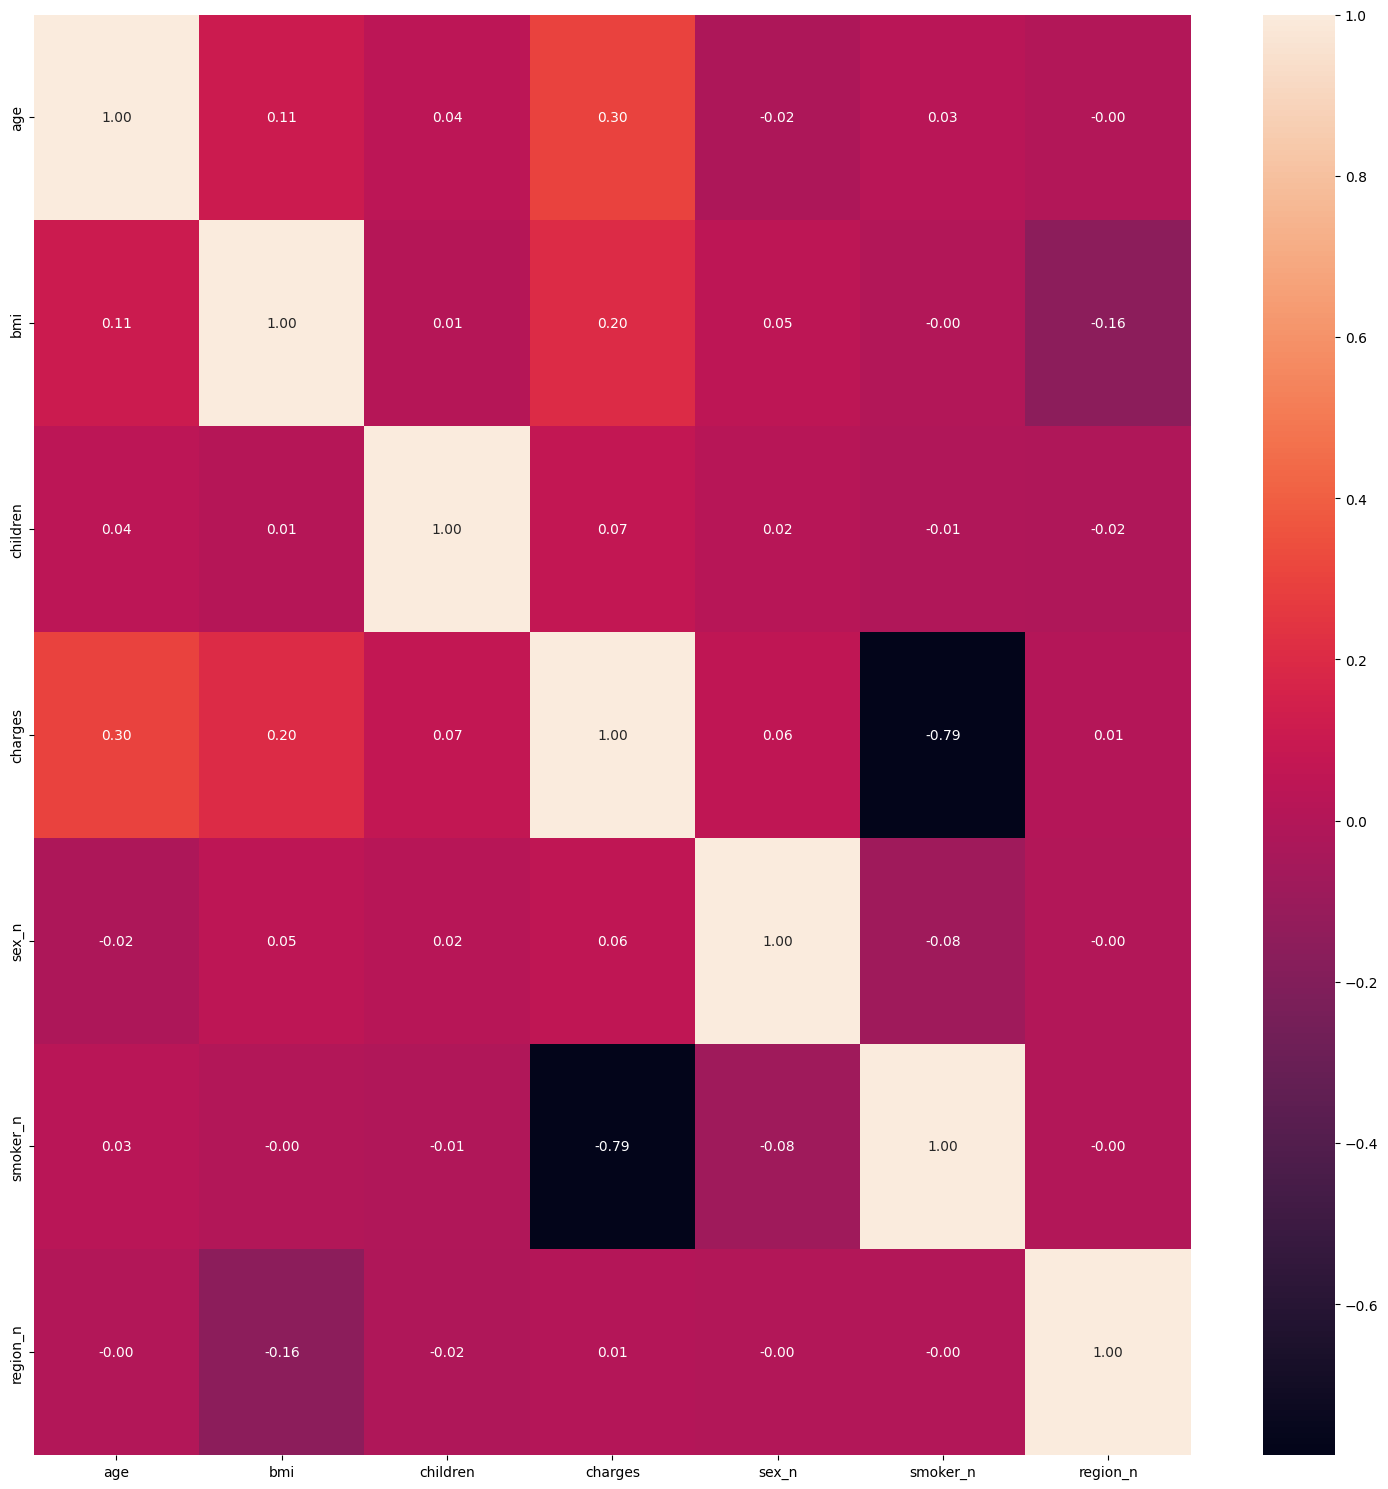

In [29]:
fig, axis = plt.subplots(figsize = (15, 15))

num_list = [col for col in df_num_total.columns if df_num_total[col].dtype == "int64" or df_num_total[col].dtype == "float64"]
df_enc = df_num_total[[col for col in df_num_total.columns if col in num_list]]
sns.heatmap(df_num_total[num_list].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

Conclusiones: 
* hay una relacción significativa entre fumadores y las primas.
* Relación ligera entre las primas con la edad y el bmi
* Una ligera influencia del 16% entre bmi y la región